In [58]:

import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split


RANDOM_SEED = 42

# Specify each path

In [59]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [60]:
NUM_CLASSES = 9

# Dataset reading

In [61]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [62]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [64]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [65]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_6 (Dropout)             │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,169 (4.57 KB)

 Trainable params: 1,169 (4.57 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [67]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [68]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step - accuracy: 0.0469 - loss: 2.4856
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0485 - loss: 2.4817 - val_accuracy: 0.0152 - val_loss: 2.3013
Epoch 2/1000
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0312 - loss: 2.5469
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0583 - loss: 2.4445 - val_accuracy: 0.0909 - val_loss: 2.2469
Epoch 3/1000
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0703 - loss: 2.3731
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0742 - loss: 2.3539 - val_accuracy: 0.1010 - val_loss: 2.2051
Epoch 4/1000
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1094 - loss: 2.2956
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.keras
5/5 ━━━━━━━━━━

In [69]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9694 - loss: 0.2149


In [70]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [71]:
# Define a threshold
THRESHOLD = 0.75

# Inference test
predict_result = model.predict(np.array([X_test[0]]))
probabilities = np.squeeze(predict_result)
max_prob = np.max(probabilities)
predicted_class = np.argmax(probabilities)

# Checks if the maximum probability exceeds the threshold.
if max_prob < THRESHOLD:
    print("No valid gesture detected, returning default class: no-gesture")
    predicted_class = 0  # Default class for 'no-gesture'

print(f"Predicted probabilities: {probabilities}")
print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted probabilities: [1.35939819e-08 3.58139592e-18 2.25311611e-15 1.17575135e-02
 9.88241494e-01 1.36160583e-09 9.46521993e-07 3.67434999e-10
 4.61330441e-09]
Predicted class: 4


# Confusion matrix

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


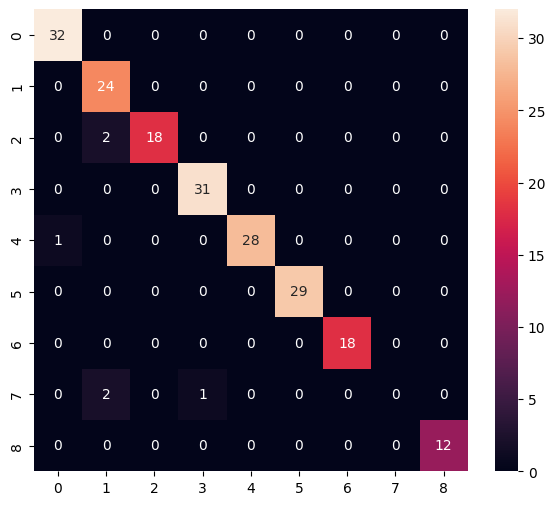

Classification Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        32
           1       0.86      1.00      0.92        24
           2       1.00      0.90      0.95        20
           3       0.97      1.00      0.98        31
           4       1.00      0.97      0.98        29
           5       1.00      1.00      1.00        29
           6       1.00      1.00      1.00        18
           7       0.00      0.00      0.00         3
           8       1.00      1.00      1.00        12

    accuracy                           0.97       198
   macro avg       0.87      0.87      0.87       198
weighted avg       0.96      0.97      0.96       198



/Users/diegobautista/Desktop/Code/python-recognize/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/diegobautista/Desktop/Code/python-recognize/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/diegobautista/Desktop/Code/python-recognize/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [73]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [74]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/cx/8g4js06d2r90rfvp53ncvhxw0000gn/T/tmpxj13gotl/assets


INFO:tensorflow:Assets written to: /var/folders/cx/8g4js06d2r90rfvp53ncvhxw0000gn/T/tmpxj13gotl/assets


Saved artifact at '/var/folders/cx/8g4js06d2r90rfvp53ncvhxw0000gn/T/tmpxj13gotl'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)
Captures:
  5991491600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5991488528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5991492752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5991489680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5991489296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5991978704: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1737489218.084786 6041234 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1737489218.085051 6041234 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


6852

# Inference test

In [75]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [76]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [77]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [78]:
# Inference implementation for TFLite
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])
probabilities = np.squeeze(tflite_results)
max_prob = np.max(probabilities)
predicted_class = np.argmax(probabilities)

# Check against threshold
if max_prob < THRESHOLD:
    print("No valid gesture detected, returning default class: no-gesture")
    predicted_class = 0  # Default class for 'no-gesture'.

print(f"TFLite predicted probabilities: {probabilities}")
print(f"TFLite predicted class: {predicted_class}")


TFLite predicted probabilities: [1.35940352e-08 3.58139634e-18 2.25312522e-15 1.17575135e-02
 9.88241494e-01 1.36160594e-09 9.46522903e-07 3.67435027e-10
 4.61331373e-09]
TFLite predicted class: 4


In [79]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.35940352e-08 3.58139634e-18 2.25312522e-15 1.17575135e-02
 9.88241494e-01 1.36160594e-09 9.46522903e-07 3.67435027e-10
 4.61331373e-09]
4
